### import libraries

In [2]:
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

### Read dataframe

In [3]:
df = pd.read_csv('slam_articles_with_country.csv')

In [16]:
# df.info()
for val in set(df['type']):
    print(f'{val}:\t{len(df[df['type'] == val])}')

monograph:	20
proceedings:	1
reference-entry:	20
edited-book:	9
proceedings-article:	14714
reference-book:	3
component:	786
other:	117
posted-content:	1974
nan:	0
dissertation:	235
peer-review:	242
book:	26
standard:	12
journal-article:	25385
dataset:	94
journal:	1
grant:	35
book-section:	21
report:	370
report-component:	76
book-chapter:	2770


### plot country distribution

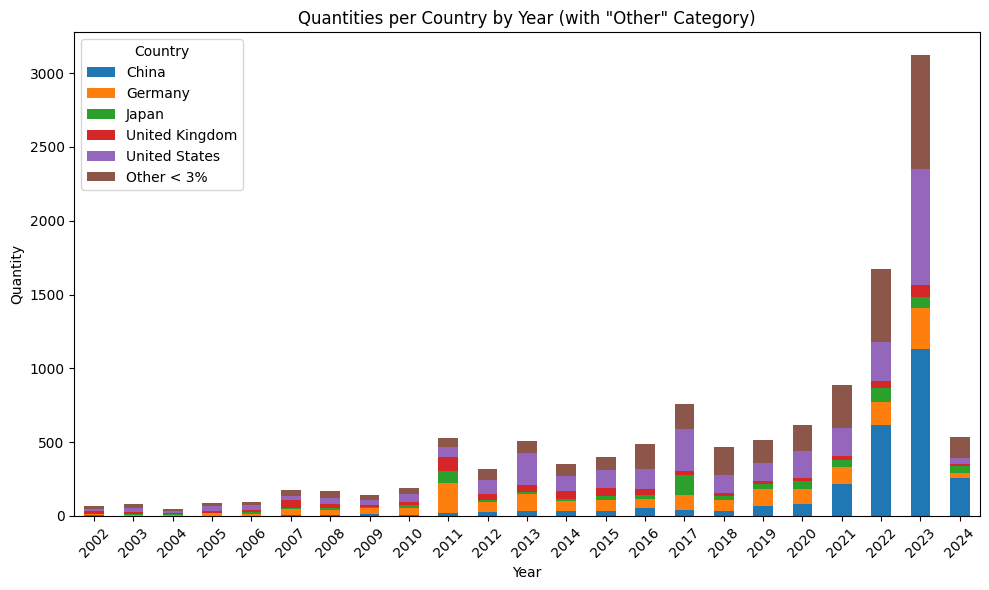

In [4]:
trh_percent = 3

copy_df = df.copy()

# copy_df = copy_df[~copy_df['country'].isin(['United States', 'China'])]

# Calculate the percentage of entries for each country
country_counts = copy_df['country'].value_counts(normalize=True) * 100

# Identify countries with less than THR of entries
small_countries = country_counts[country_counts < trh_percent].index

# Replace these countries with 'Other' in the dataframe
copy_df['country_adjusted'] = copy_df['country'].apply(lambda x: f'Other < {trh_percent}%' if x in small_countries else x)

# Aggregate the data again with the adjusted country column
agg_data_adjusted = copy_df.groupby(['year', 'country_adjusted']).size().unstack(fill_value=0)

# If 'Other' exists, move it to the end of the DataFrame for better visualization
if f'Other < {trh_percent}%' in agg_data_adjusted.columns:
    cols = [col for col in agg_data_adjusted if col != f'Other < {trh_percent}%'] + [f'Other < {trh_percent}%']
    agg_data_adjusted = agg_data_adjusted[cols]

# Plotting the adjusted data
agg_data_adjusted.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Quantities per Country by Year (with "Other" Category)')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend(title='Country')
plt.tight_layout()

# Show the plot
plt.show()